# Modules

Analyze modules: local and external modules, import type, test modules.

In [1]:
import pandas as pd

from database import connect
from h4_analysis_helpers import display_counts, getitem
from h4_analysis_helpers import relative_var, savefig
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from IPython.display import display
from collections import Counter

%matplotlib inline

In [5]:
with connect() as session:
    modules = pd.read_sql_table("notebook_modules", session.connection())
    print('Total of Modules:', len(modules))

Total of Modules: 273


In [6]:
with connect() as session:
    query = (
        "SELECT count(id) "
        "FROM notebooks "
        "WHERE NOT (kernel = 'no-kernel' AND nbformat = '0') "
        "AND language = 'python' "
        "AND language_version != 'unknown' "
        "AND total_cells != 0 "
        "AND processed & 16 = 0 "
    )
    result = session.execute(query)
    total_valid_python_notebooks = result.scalar()
    
    print('Valid Python Notebooks: {}'.format(total_valid_python_notebooks))


Valid Python Notebooks: 314


In [7]:
columns = [
    "any_any", "local_any", "external_any",
    "any_import_from", "local_import_from", "external_import_from",
    "any_import", "local_import", "external_import",
    "any_load_ext", "local_load_ext", "external_load_ext",
]
count_columns = [c + "_count" for c in columns]
for column in columns:
    modules[column] = modules[column].apply(lambda c: {a for a in c.split(",") if a})
    modules["toplevel_" + column] = modules[column].apply(lambda imports: {
        getitem(x.split("."), 0, x) for x in imports
    })
    modules["toplevel_" + column + "_count"] = modules["toplevel_" + column].apply(len)

modules.head(5)

,id,repository_id,notebook_id,index,index_count,any_any,any_any_count,local_any,local_any_count,external_any,...,toplevel_local_import,toplevel_local_import_count,toplevel_external_import,toplevel_external_import_count,toplevel_any_load_ext,toplevel_any_load_ext_count,toplevel_local_load_ext,toplevel_local_load_ext_count,toplevel_external_load_ext,toplevel_external_load_ext_count
0,1,1,1,"4,8,23,48,50",5,"{seaborn, sklearn.decomposition, sklearn.datas...",5,{},0,"{seaborn, sklearn.decomposition, sklearn.datas...",...,{},0,"{matplotlib, seaborn, numpy}",3,{},0,{},0,{},0
1,2,1,2,,0,{},0,{},0,{},...,{},0,{},0,{},0,{},0,{},0
2,3,1,3,,0,{},0,{},0,{},...,{},0,{},0,{},0,{},0,{},0
3,4,1,4,"5,13,16",3,"{numexpr, pandas, numpy}",3,{},0,"{numexpr, pandas, numpy}",...,{},0,"{numexpr, pandas, numpy}",3,{},0,{},0,{},0
4,5,1,5,,0,{},0,{},0,{},...,{},0,{},0,{},0,{},0,{},0


# Notebooks with modules

In [8]:
total_notebooks_with_modules = len(modules[modules["any_any_count"] > 0])
relative_var("notebooks_with_modules", total_notebooks_with_modules, total_valid_python_notebooks)

'243 (77.39%)'

# Local vs External

In [9]:
local = modules["local_any_count"].sum()
external = modules["external_any_count"].sum()
local, external

(10, 1497)

## By notebook

In [10]:
local_notebook = modules[modules["local_any_count"] > 0]
external_notebook = modules[modules["external_any_count"] > 0]

### Local

In [11]:
relative_var("notebooks_with_local_modules", len(local_notebook), total_valid_python_notebooks)

'9 (2.87%)'

### External

In [12]:
relative_var("notebooks_with_external_modules", len(external_notebook), total_valid_python_notebooks)

'243 (77.39%)'

### Venn

In [13]:
local_ids = set(local_notebook.index.tolist())
external_ids = set(external_notebook.index.tolist())
len(local_ids & external_ids)

9

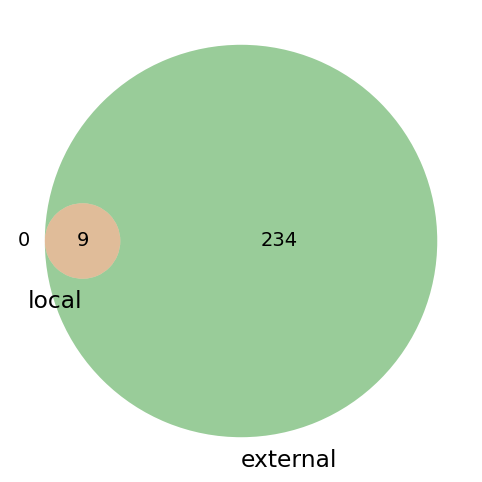

In [14]:
with savefig(f"notebook_module_external_local", 8, 6):
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    venn = venn2(subsets=(local_ids, external_ids), set_labels=('local', 'external'), ax=ax)
    for label in venn.subset_labels:
        label.set_text("{0:,g}".format(int(label.get_text())))
    local_label = venn.subset_labels[0]
    xy = local_label.get_position()
    xy = (xy[0] - 0.06, xy[1])
    local_label.set_position(xy)


# Import Type

* import: `import numpy`
* import_from: `from sklearn import datasets`
* load_ext: `%load_ext autoreload`


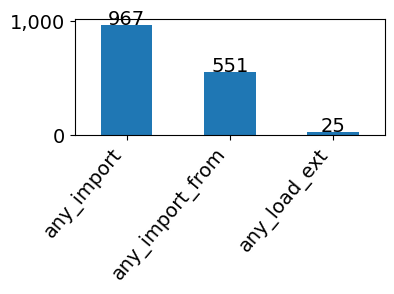

In [15]:
count = modules[["any_import_count", "any_import_from_count", "any_load_ext_count"]].sum()\
    .rename(lambda x: x[:-6]).sort_values(ascending=False)

fig2, counts2 = display_counts(count, width=4, show_values=True, template="{0:,}", plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()
# display(counts2)

## Local

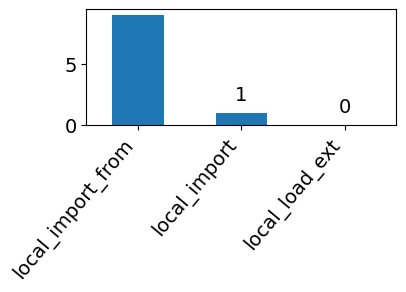

In [16]:
count = modules[["local_import_count", "local_import_from_count", "local_load_ext_count"]]\
    .sum().rename(lambda x: x[:-6]).sort_values(ascending=False)

fig3, counts3 = display_counts(count, width=4, show_values=True, template="{0:,}",
                               plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")

plt.show()
# display(counts3)

## External

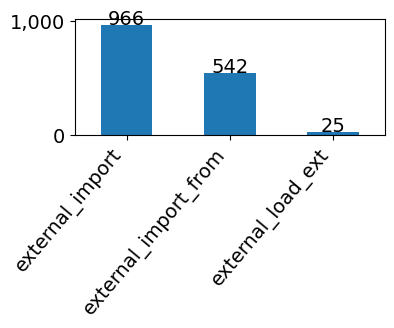

In [17]:
count = modules[["external_import_count", "external_import_from_count","external_load_ext_count"]]\
    .sum().rename( lambda x: x[:-6]).sort_values(ascending=False)

fig4, counts4 = display_counts(count, width=4, show_values=True,
                               template="{0:,}", plot=False, logy=False)
ax = plt.gca()
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")

plt.show()
# display(counts4)

# Which modules

## General

### Full import

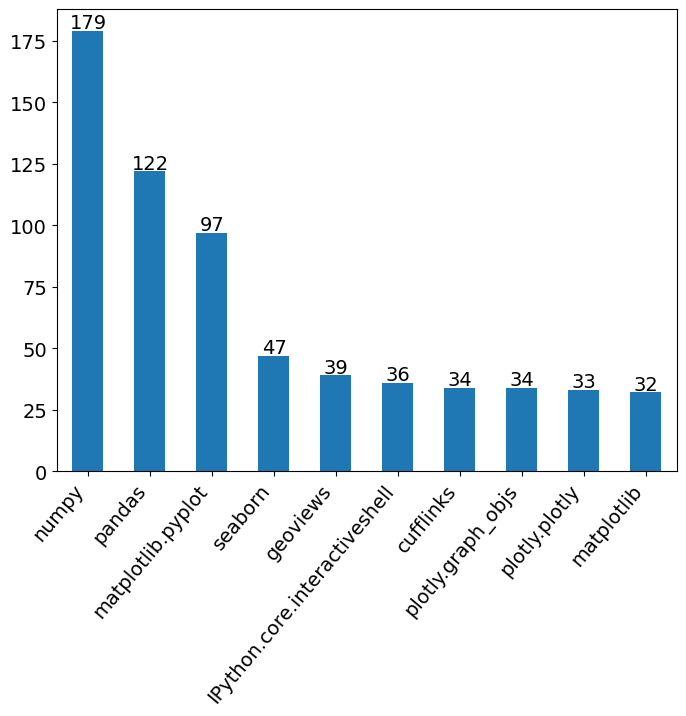

In [18]:
counter = Counter()
modules["any_any"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_full_import", 8, 6):
    fig5, count5 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count5)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)

### Toplevel

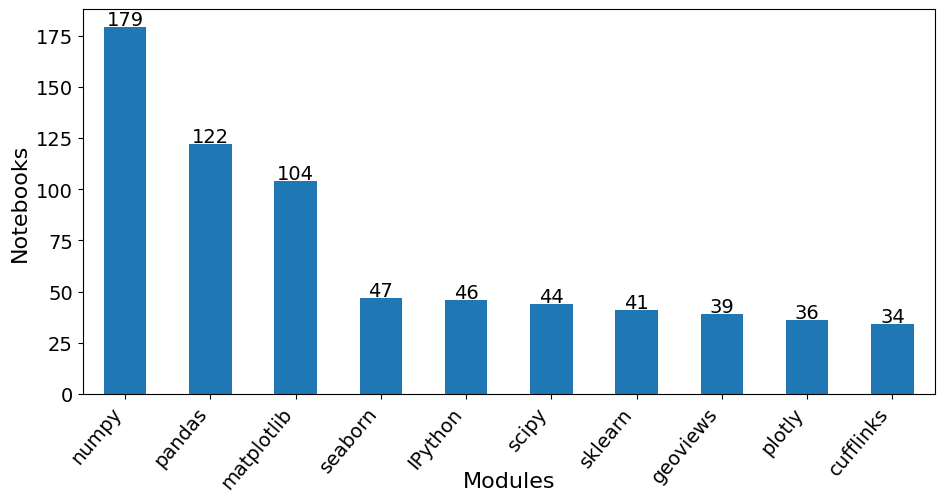

In [19]:
counter = Counter()
modules["toplevel_any_any"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_toplevel", 11, 5):
    fig6, count6 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count6)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)
    ax.set_ylabel("Notebooks")
    ax.set_xlabel("Modules")
    ax.xaxis.labelpad = -15
    #ax.yaxis.labelpad = -15

#### Percentage

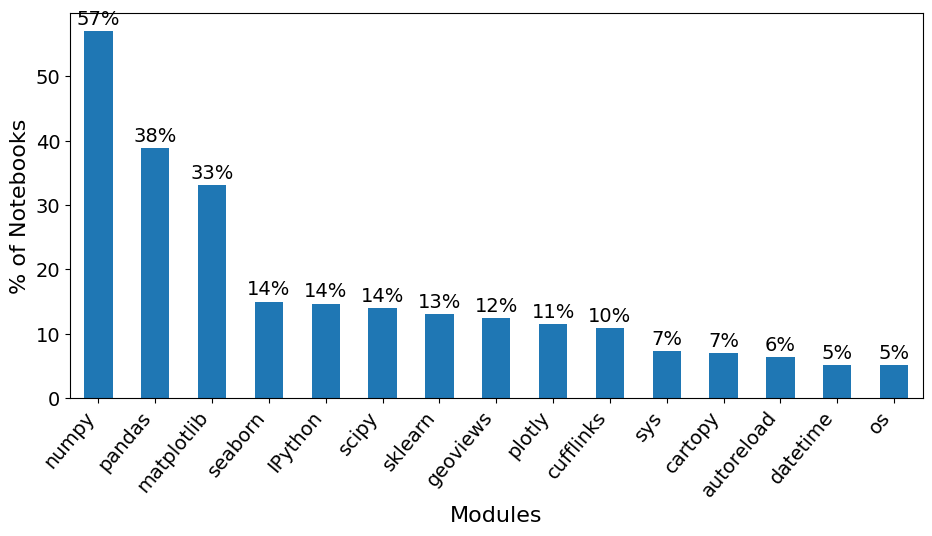

In [20]:
ncounts = counts / total_valid_python_notebooks * 100
with savefig("notebook_module_toplevel_percentage", 11, 5):
    fig, count7 = display_counts(
        ncounts, width=20, show_values=True, plot=False,
        cut=slice(None, 15), logy=False, template="{}%"
    )
    # display(count7)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)
    ax.set_ylabel("% of Notebooks")
    ax.set_xlabel("Modules")

## import

### Full import

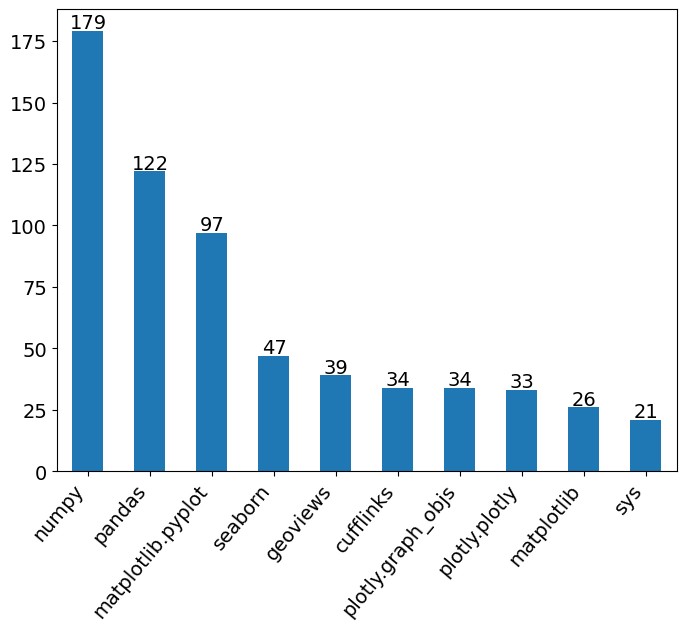

In [21]:
counter = Counter()
modules["any_import"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_import_full_import", 8, 6):
    fig8, count8 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count8)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


### Toplevel

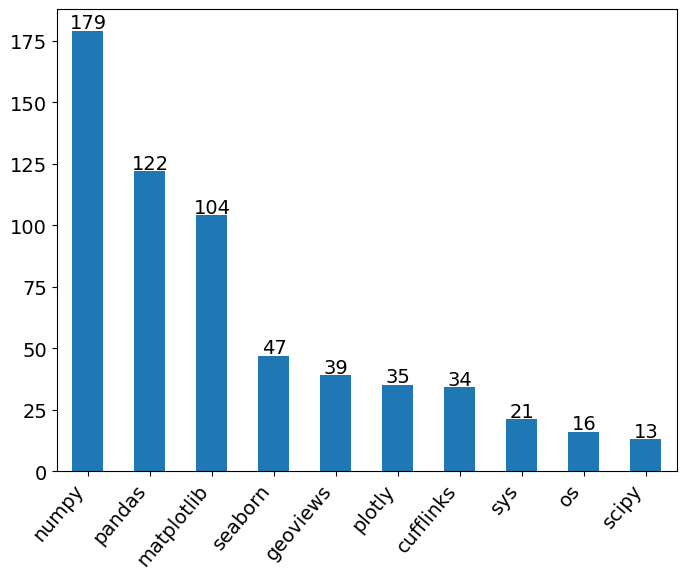

In [22]:
counter = Counter()
modules["toplevel_any_import"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_import_toplevel", 8, 6):
    fig9, count9 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count9)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


## import_from

### Full import

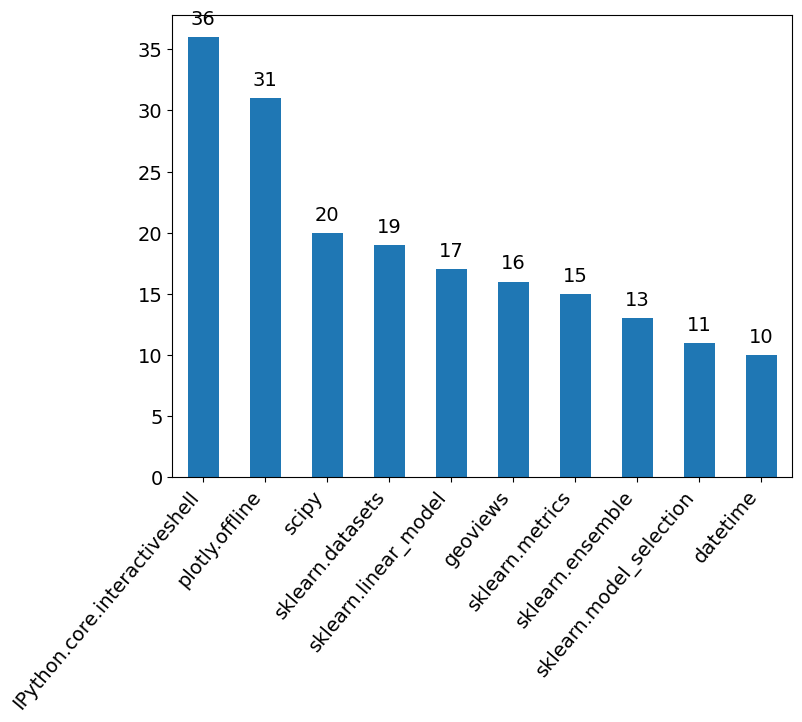

In [23]:
counter = Counter()
modules["any_import_from"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_import_from_full_import", 8, 6):
    fig10, count10 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count10)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


### Toplevel

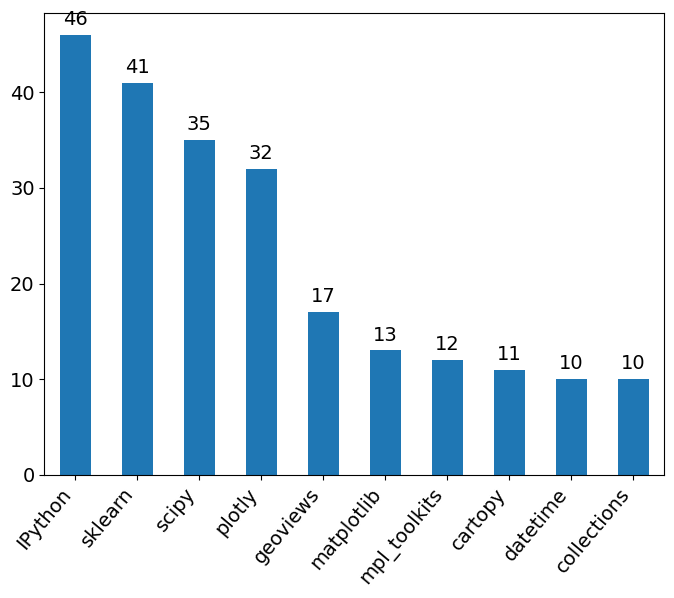

In [24]:
counter = Counter()
modules["toplevel_any_import_from"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_import_from_toplevel", 8, 6):
    fig11, count11 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count11)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


## load_ext

### Full import

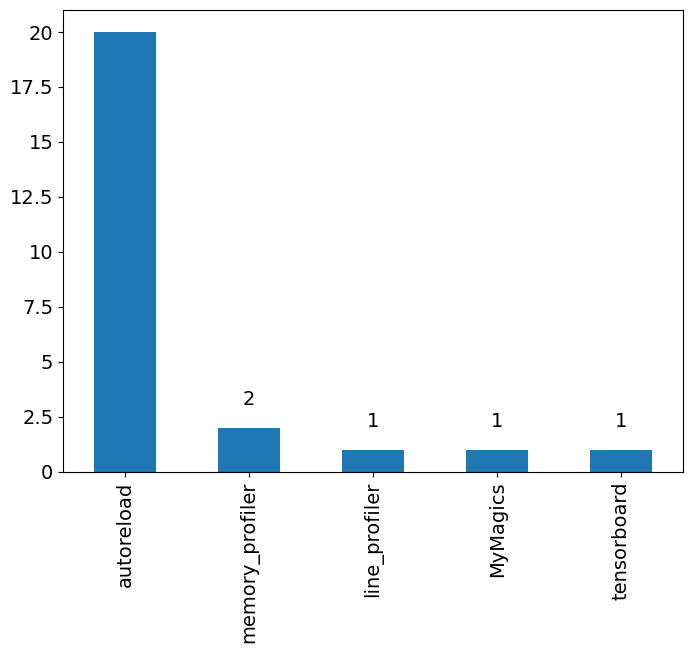

In [25]:
counter = Counter()
modules["any_load_ext"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_load_ext_full_import", 8, 6):
    fig12, count12 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count12)
    ax = plt.gca()
    ax.legend().set_visible(False)


### Toplevel

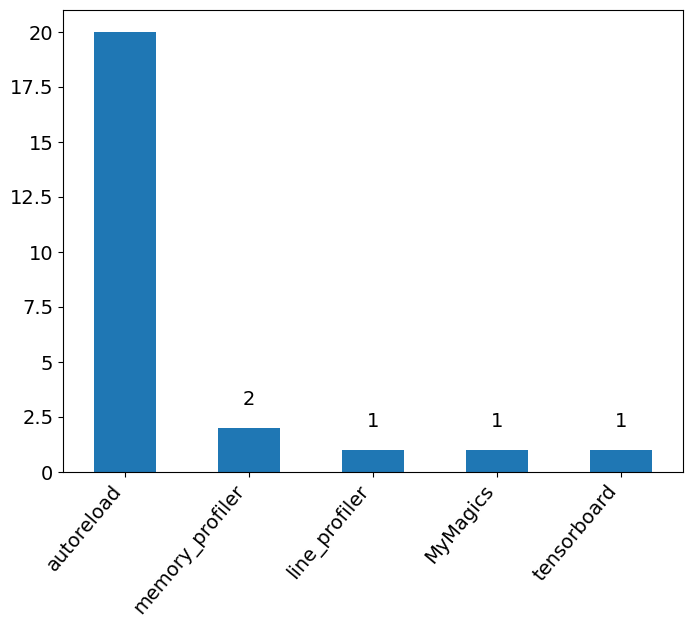

In [26]:
counter = Counter()
modules["toplevel_any_load_ext"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with savefig("notebook_module_load_ext_toplevel", 8, 6):
    fig13, count13 = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    # display(count13)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.legend().set_visible(False)


# Test-related modules

In [27]:
counter = Counter()
modules["any_any"].agg(lambda x: counter.update({
    y for y in x
    if "test" in y
    or "TEST" in y
    or "Test" in y
}))
del counter['']
counts = pd.Series(counter, dtype='float64').sort_values(ascending=False)
if len(counts) > 0:
    with savefig("notebook_tests", 8, 4):
        fig, cnt = display_counts(
            counts, width=20, show_values=True, plot=False,
            cut=slice(None, 15), logy=False
        )
        display(cnt)
        ax = plt.gca()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
        ax.legend().set_visible(False)


In [28]:
relative_var(
    "notebooks_with_test",
    len(modules[modules["any_any"].apply(lambda x: any((
        "test" in y
        or "TEST" in y
        or "Test" in y
    ) for y in x))]),
    total_valid_python_notebooks
)

'0 (0.00%)'

In [29]:
relative_var(
    "notebooks_with_unittest", 
    len(modules[modules["any_any"].apply(lambda x: "unittest" in x)]),
    total_valid_python_notebooks
)

'0 (0.00%)'